In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
"PLANT VILLAGE",
shuffle=True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),   
batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names  # class_names is an attribute of dataset
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
68*32

2176

In [7]:
for image_batch,label_batch in dataset.take(1): # .take(1) will give result of 1 batch
    print(image_batch.shape)
    print(label_batch.numpy()) # where 0,1,2 are 'Potato___Early_blight','Potato___Late_blight', Potato___healthy' respectively.

(32, 256, 256, 3)
[0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 2 0 0 0 0 2]


In [8]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].numpy())   # .numpy() changes image from tensor to numpy

[[[182. 185. 202.]
  [182. 185. 202.]
  [172. 175. 192.]
  ...
  [104. 101. 120.]
  [105. 102. 121.]
  [143. 140. 159.]]

 [[171. 174. 191.]
  [173. 176. 193.]
  [166. 169. 186.]
  ...
  [107. 104. 123.]
  [124. 121. 140.]
  [111. 108. 127.]]

 [[162. 165. 182.]
  [166. 169. 186.]
  [161. 164. 181.]
  ...
  [103. 100. 119.]
  [123. 120. 139.]
  [118. 115. 134.]]

 ...

 [[183. 185. 198.]
  [179. 181. 194.]
  [174. 176. 189.]
  ...
  [113. 109. 123.]
  [119. 115. 129.]
  [130. 126. 140.]]

 [[180. 182. 195.]
  [179. 181. 194.]
  [177. 179. 192.]
  ...
  [129. 125. 139.]
  [111. 107. 121.]
  [113. 109. 123.]]

 [[173. 175. 188.]
  [178. 180. 193.]
  [183. 185. 198.]
  ...
  [130. 126. 140.]
  [112. 108. 122.]
  [ 81.  77.  91.]]]


In [9]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


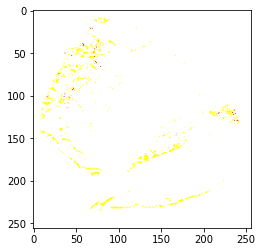

In [10]:
for image_batch,label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy()) # imshow() expects 3d array

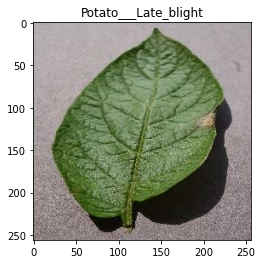

In [11]:
for image_batch,label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8')) # converted data from float to int
    plt.title(class_names[label_batch[0]])
    #plt.axis('off')

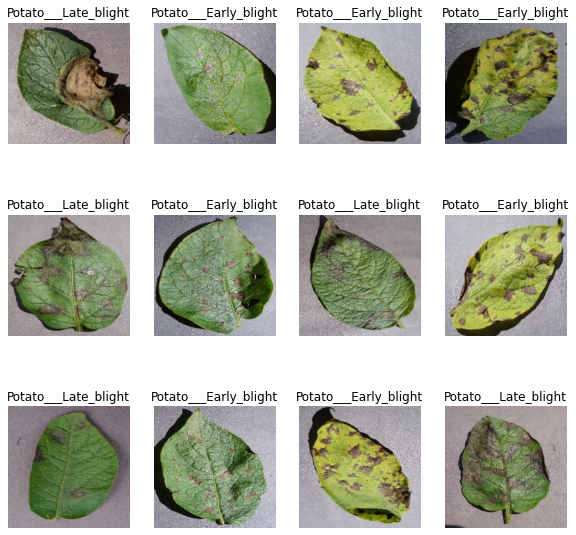

In [12]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8')) 
        plt.title(class_names[label_batch[i]])
        plt.axis('off')
   

In [13]:
len(dataset)

68

In [14]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

In [15]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [16]:
train_ds= dataset.take(54) 
len(train_ds)
# train_ds means training dataset
# tensorflow doesnot have train test split. Here dataset.take() is used for taking data.
# 54 is first 54 batch of samples (out of 68) used for training.

54

In [20]:
test_ds_all= dataset.skip(54)  # skip first 54 batchees and takes all after that
len(test_ds_all)

14

In [21]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [22]:
val_ds= test_ds_all.take(6)
len(val_ds)

6

In [23]:
test_ds=test_ds_all.skip(6)
len(test_ds)

8

In [24]:
def get_dataset_partitions_tf (ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds =ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [25]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [26]:
len(train_ds)

54

In [27]:
len(val_ds)

6

In [28]:
len(test_ds)

8

In [29]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [30]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [31]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [36]:
input_shape= (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_13 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                 

In [40]:
model.compile(
     optimizer='adam',
     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
     metrics=['accuracy']
)

In [41]:
history=model.fit(
     train_ds,
     epochs=EPOCHS,
     batch_size=BATCH_SIZE,
     validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 66s 1s/step - loss: 0.9033 - accuracy: 0.4751 - val_loss: 0.8961 - val_accuracy: 0.5677
Epoch 2/50
54/54 [==============================] - 58s 1s/step - loss: 0.6839 - accuracy: 0.6800 - val_loss: 0.5331 - val_accuracy: 0.7708
Epoch 3/50
54/54 [==============================] - 56s 1s/step - loss: 0.5111 - accuracy: 0.7749 - val_loss: 0.4298 - val_accuracy: 0.8333
Epoch 4/50
54/54 [==============================] - 54s 1s/step - loss: 0.3830 - accuracy: 0.8385 - val_loss: 0.3811 - val_accuracy: 0.8490
Epoch 5/50
54/54 [==============================] - 55s 1s/step - loss: 0.2764 - accuracy: 0.8924 - val_loss: 0.3963 - val_accuracy: 0.8177
Epoch 6/50
54/54 [==============================] - 54s 998ms/step - loss: 0.2343 - accuracy: 0.9010 - val_loss: 0.1631 - val_accuracy: 0.9427
Epoch 7/50
54/54 [==============================] - 54s 1s/step - loss: 0.2678 - accuracy: 0.9010 - val_loss: 0.6451 - val_accuracy: 0.7448
Epoch 8/50
54/54 

In [42]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 184ms/step - loss: 0.0385 - accuracy: 0.9805


In [43]:
scores

[0.038509827107191086, 0.98046875]

In [45]:
history

In [46]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [47]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [48]:
history.history['accuracy']
# len(history.history['accuracy'])

[0.47511574625968933,
 0.6799768805503845,
 0.7748842835426331,
 0.8385416865348816,
 0.8923611044883728,
 0.9010416865348816,
 0.9010416865348816,
 0.8964120149612427,
 0.953125,
 0.9658564925193787,
 0.9762731194496155,
 0.984375,
 0.9583333134651184,
 0.9716435074806213,
 0.9797453880310059,
 0.9675925970077515,
 0.9780092835426331,
 0.9710648059844971,
 0.9519675970077515,
 0.9699074029922485,
 0.9762731194496155,
 0.9820601940155029,
 0.9820601940155029,
 0.9756944179534912,
 0.9895833134651184,
 0.9855324029922485,
 0.9797453880310059,
 0.9861111044883728,
 0.9820601940155029,
 0.9785879850387573,
 0.9924768805503845,
 0.9890046119689941,
 0.9866898059844971,
 0.9872685074806213,
 0.9890046119689941,
 0.9895833134651184,
 0.9936342835426331,
 0.9982638955116272,
 0.9855324029922485,
 0.9878472089767456,
 0.9953703880310059,
 0.9890046119689941,
 0.9797453880310059,
 0.9895833134651184,
 0.9913194179534912,
 0.9936342835426331,
 0.9913194179534912,
 0.9907407164573669,
 0.98958331

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

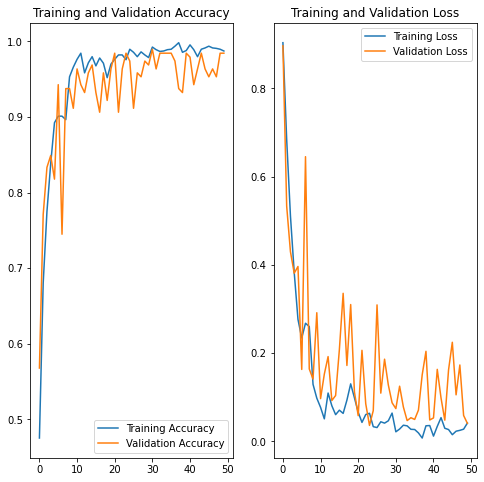

In [56]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)  # means figure has 1 row and 2 column and it is 1st plot
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')           
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2) # means figure has 1 row and 2 column and it is 2nd plot 
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')          (# for plots above one another use (2,1,1) and (2,1,2))   
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

first image to predict
first image's actual label: Potato___Early_blight
1/1 [==============================] - 0s 210ms/step
predicted label: Potato___Early_blight


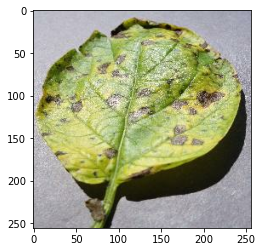

In [62]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:",class_names[first_label])
    
    batch_prediction=model.predict(images_batch)
    #print("predicted label:",batch_prediction[0])
    #print("predicted label:",np.argmax(batch_prediction[0]))
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [63]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) # Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence
    

1/1 [==============================] - 0s 29ms/step


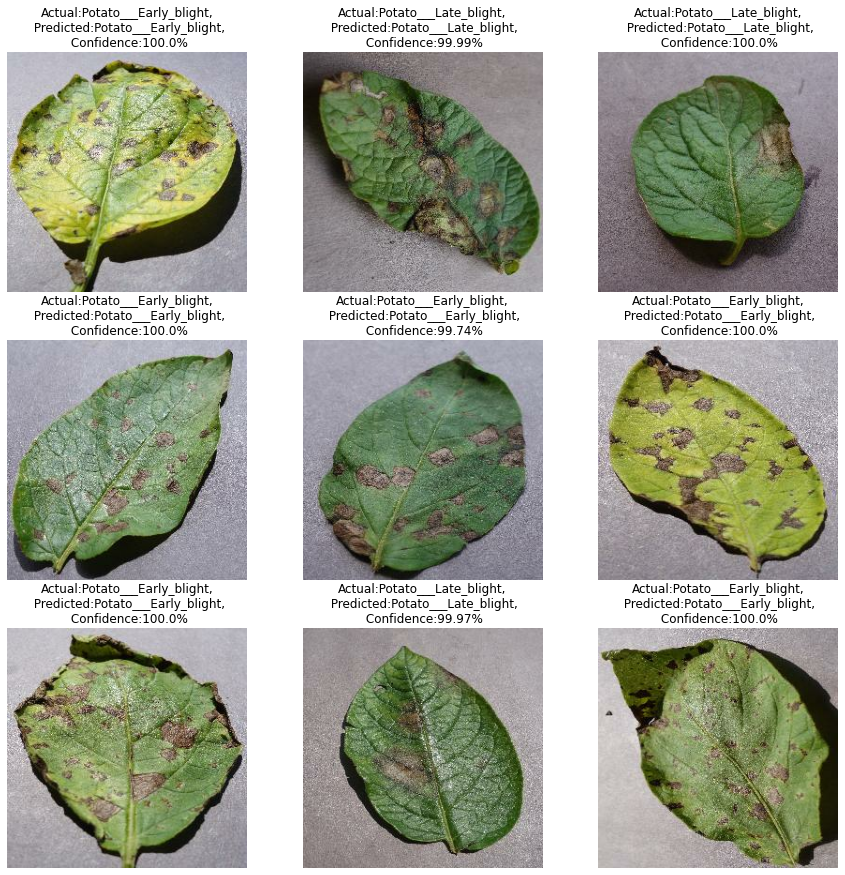

In [65]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):       # taking 1 batch(32 images) from test dataset
    for i in range(9):                       # checking only 9 images
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class},\n Confidence:{confidence}%")
        plt.axis("off")